# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is
divided into two parts: in the first part, we will implement a specific type of GAN designed to
process images, called a Deep Convolutional GAN (DCGAN). We’ll train the DCGAN to generate
emojis from samples of random noise. In the second part, we will apply some methods that researchers have suggested to "stablize" the training process of GANs and then train our DCGAN again.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process.

In [0]:
!nvidia-smi

Mon Apr 27 12:08:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
# Uncomment and run these in Colab
%tensorflow_version 1.4
!pip install --upgrade opencv-python==3.4.2.17
!pip install keras

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
     |████████████████████████████████| 25.0MB 195kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [2]:
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from keras.preprocessing import image as k_image
from keras.utils.generic_utils import Progbar
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
import random

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ROLLNUMBER = 20100186
BATCH_SIZE = 128
IMAGE_SHAPE = [64,64]
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 2001
# Use this to prefix all your paths when reading/writing data to drive.
BASE_DIR = '/content/drive/My Drive/DL Assignments/PA 05'

In [0]:
!unzip "/content/drive/My Drive/DL Assignments/PA 05/filtered_emojis.zip" -d "/content"

Archive:  /content/drive/My Drive/DL Assignments/PA 05/filtered_emojis.zip
  inflating: /content/filtered_emojis/U+1F937 U+200D U+2642 U+FE0F.png  
  inflating: /content/filtered_emojis/U+1F937 U+1F3FF.png  
  inflating: /content/filtered_emojis/U+1F939 U+1F3FC U+200D U+2642 U+FE0F.png  
  inflating: /content/filtered_emojis/U+1F939 U+1F3FD U+200D U+2642 U+FE0F.png  
  inflating: /content/filtered_emojis/U+1F939.png  
  inflating: /content/filtered_emojis/U+1F939 U+1F3FF.png  
  inflating: /content/filtered_emojis/U+1F939 U+1F3FE U+200D U+2642 U+FE0F.png  
  inflating: /content/filtered_emojis/U+1F939 U+1F3FF U+200D U+2642 U+FE0F.png  
  inflating: /content/filtered_emojis/U+1F939 U+1F3FB U+200D U+2640 U+FE0F.png  
  inflating: /content/filtered_emojis/U+1F937.png  
  inflating: /content/filtered_emojis/U+1F937 U+200D U+2640 U+FE0F.png  
  inflating: /content/filtered_emojis/U+1F939 U+1F3FB U+200D U+2642 U+FE0F.png  
  inflating: /content/filtered_emojis/U+1F939 U+1F3FC.png  
  inflati

In [0]:
cd "/content"

/content


- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

## PART 1: Deep Convolutional GAN (DCGAN)
For the first part of this assignment, we will implement a Deep Convolutional GAN (DCGAN).
A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.
We will develop each of these three components in the following subsections.

In [0]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data():
    base_dir = 'filtered_emojis/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

### Implementing the Discriminator of the DCGAN
The discriminator in this DCGAN is a convolutional neural network that has the following architecture:
<br>
![DCGAN Discriminator](DCGAN_disc.png)
<br>

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: padding='same',use_bias=False
- After the last convolutional layer, Flatten the output and then add the final dense layer for prediction
- Use kernel_size of (4,4), except the last one -- You may change this ((4,4) one) but don't reduce it too much
- Reduce the spatial dimension by a factor of 2 after each convolution, except the last one.
- Use LeakyRelu and BatchNormalization after each convolution

Implement the discriminator in the cell below:

In [0]:
def old_build_discriminator():
    input_15 = keras.Input(shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), name = 'input_15')

    conv2d_31 = Conv2D(64, (4,4), padding = 'same', use_bias=False, strides=2) (input_15)
    lu_37 = LeakyReLU() (conv2d_31)

    conv2d_32 = Conv2D(128, (4,4), padding = 'same', use_bias=False, strides=2) (lu_37)
    bn_31 = BatchNormalization() (conv2d_32)
    lu_38 = LeakyReLU() (bn_31)

    conv2d_33 = Conv2D(256, (4,4), padding = 'same', use_bias = False, strides = 2) (lu_38)
    bn_32 = BatchNormalization() (conv2d_33)
    lu_39 = LeakyReLU() (bn_32)

    conv2d_34 = Conv2D(512, (4,4), padding = 'same', use_bias = False, strides = 2) (lu_39)
    bn_33 = BatchNormalization() (conv2d_34)
    lu_40 = LeakyReLU() (bn_33)

    conv2d_35 = Conv2D(1, (2,2), padding = 'same', use_bias = False, strides = 1) (lu_40)
    f_7 = Flatten() (conv2d_35)
    d_11 = Dense(1, activation='sigmoid') (f_7)

    disc = keras.Model(inputs = input_15, output = d_11)
    return disc

### Implementing the generator of DCGAN
Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose
convolutional layers that progressively upsample the input noise sample to generate a fake image.
The generator has the following architecture:
<br>
![DCGAN Generator](DCGAN_gen.png)

**Some important points:**
- Pass in use_bias=False,padding='same' in your convolutional layers.
- All intermediate convolutional layers will have relu activation except the last one, which will have tanh.
- All other properties can be inferred from the above diagram

Implement the generator in the cell below

In [0]:
def old_build_generator():
    rs_1 = keras.Input(shape=(NOISE_DIM,), name = 'rs_1')

    dl_0 = Dense(4*4*1024)(rs_1)
    reshp = Reshape((4,4,1024)) (dl_0)

    cl_0 = Conv2DTranspose(512, (4,4), padding='same', use_bias= False, strides=(2,2)) (reshp)
    bn_0 = BatchNormalization() (cl_0)
    lu_0 = LeakyReLU() (bn_0)

    cl_1 = Conv2DTranspose(256, (4,4), padding = 'same', use_bias = False, strides=(2,2)) (lu_0)
    lu_1 = LeakyReLU() (cl_1)
    
    cl_2 = Conv2DTranspose(128, (4,4), padding = 'same', use_bias = False, strides=(2,2)) (lu_1)
    bn_2 = BatchNormalization() (cl_2)
    lu_2 = LeakyReLU() (bn_2)

    cl_4 = Conv2DTranspose(3, (4,4), activation='tanh', padding = 'same', use_bias = False, strides=(2,2)) (lu_2)
    #fl_4 = Flatten() (cl_4)
    #dl_4 = Dense(1, activation='tanh') (fl_4)

    genr = Model(inputs = rs_1, output = cl_4)
    return genr

### DCGAN Training Loop
Next, you will implement the training loop for the DCGAN. A DCGAN is simply a GAN with a
specific type of generator and discriminator; thus, we train it in exactly the same way as a standard
GAN. The pseudo-code for the training procedure is shown below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Compute discriminator's loss on real images and fake images batches and then update the parameters.
5. Draw m NEW noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input (Matching the noise dimensions defined at the top of the notebook)
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.

Remember to compile the model before returning it.

In [0]:
def build_gan(gen,disc):
    inp = Input(shape=(NOISE_DIM,))
    #print(inp.shape)
    img = gen(inp)
   #print(img.shape)
    for layer in disc.layers:
      layer.trainable = False

    out = disc(img)
   # print(out.shape)
    out_model = Model(inputs= inp, outputs = out)
    out_model.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0005))
    
    return out_model

Write your training loop in the cell bellow. Some important points to keep in mind:
- You need to compile the discriminator after creating an instance using build_discriminator()
- Use the provided load_data() function to well... load the data. You can choose between generating Windows or Apple emojis
- The entire data will be loaded as it is small enough to fit into memory (Finally no data generators, right?) BUT you still need to loop over the data in batches. Starter code is provided to you.
- To train your models, we won't make use of <code>fit</code> instead we will use <code>train_on_batch</code> to train our model over batches. This method will return your model's loss over a particular batch, which you will use to output and store your history of losses.
- Additionally, we will be generating samples after some epochs and storing the result on disk. The code is provided to do this.

In [0]:
def save_samples(generated_images,step,save_at="samples/"):
    sample_image = create_image_grid(generated_images)
    img = k_image.array_to_img(sample_image)
    img.save(os.path.join(BASE_DIR,save_at, 'generated_image_' + str(step) + '.png'))

In [0]:
def old_gan_training_loop(intervals=200):
    # Setup Models here
    discriminator = old_build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0002))
    
    #noise = sample_noise()
    generator = old_build_generator()
    generator.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0002))
    dcgan = build_gan(generator, discriminator)

    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here
            real_labels = np.ones((BATCH_SIZE,), dtype=int)
            fake_labels = np.zeros((BATCH_SIZE,), dtype=int)

            noise = sample_noise()
            train_sam = X_train[index:index+BATCH_SIZE]

            generated_imgs = generator.predict(noise)

            real_disc = discriminator.train_on_batch(train_sam, real_labels)
            fake_disc = discriminator.train_on_batch(generated_imgs, fake_labels)

            if not (e % intervals):
                save_samples(generated_imgs,e, "unstable samples/")     
            
            disc_loss = (real_disc + fake_disc) * 0.5
            epoch_disc_loss.append(disc_loss)
            
            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            for layer in discriminator.layers:
              layer.trainable = False

            # Unfreeze after your call to train_on_batch
            new_noise = sample_noise()
            gen_train = dcgan.train_on_batch(new_noise, real_labels)
            gen_loss = gen_train

            for layer in discriminator.layers:
              layer.trainable = True

            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
            # Save weights here
            discriminator.save_weights(os.path.join(BASE_DIR,'discriminator'),True)
            generator.save_weights(os.path.join(BASE_DIR,'generator'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

### Training the GAN
We will train a DCGAN to generate fake Apple emojis. 1 epoch should take about 15 seconds on Google Colab.

Train your DCGAN in the below cell

In [0]:
old_disc_loss, old_gen_loss = old_gan_training_loop()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("rs..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5/5 [==============================] - 5s 1s/step
Epoch: 1 | Discriminator Loss: 1.668902 | Generator Loss: 1.440024
5/5 [==============================] - 1s 186ms/step
Epoch: 2 | Discriminator Loss: 0.508485 | Generator Loss: 3.404763
5/5 [==============================] - 1s 186ms/step
Epoch: 3 | Discriminator Loss: 0.066006 | Generator Loss: 1.570388
5/5 [==============================] - 1s 187ms/step
Epoch: 4 | Discriminator Loss: 0.004944 | Generator Loss: 0.072549
5/5 [==============================] - 1s 183ms/step
Epoch: 5 | Discriminator Loss: 0.003324 | Generator Loss: 0.031578
5/5 [==============================] - 1s 185ms/step
Epoch: 6 | Discriminator Loss: 0.002717 | Generator Loss: 0.024524
5/5 [==============================] - 1s 185ms/step
Epoch: 7 | Discriminator Loss: 0.002416 | Generator Loss: 0.025739
5/5 [==============================] - 1s 188ms/step
Epoch: 8 | Discriminator Loss: 0.002522 | Generator Loss: 0.062545
5/5 [==============================] - 1s 1

### Generating Samples and Analysis

- Plot your discriminator and generator losses and explain how it represents the MiniMax game in play, and comment on the trends you observe.
- Generate random 5 noise samples and their corresponding fake images.
- Mention if you observe any failure modes
- **BONUS (5%):** Try generating some good samples, and try interpolating the input noise samples (Vector Arithmetic) to see if the results are as expected.

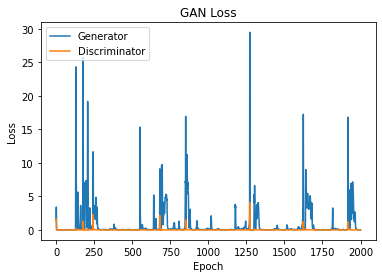

In [0]:
plot_loss(old_gen_loss, old_disc_loss)

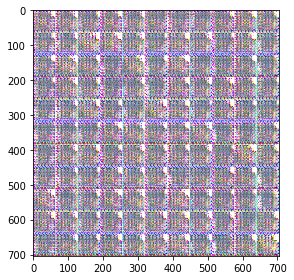

In [0]:
imgU_path = '/content/drive/My Drive/DL Assignments/PA 05/unstable samples/generated_image_2000.png'
imgU = imread(imgU_path)
imshow(imgU)

The Model showed lots of variation throughout the process. I had to tweak parameters again and again still model stayed highly unstable and volatile.

Model does not converge to a stage where it starts to output emojis. Rather, it just kept generating variety of noisy outputs. However, there is a slight artifact of emojis visible in latest epoch. So, it can be inferred that input data is highly volatile and noisy which is making difficult for model to a convergence point.

It can also be observed from plot that generator is highly unstable as it loss spikes keep rising to 30% given 2-3% loss variation in discriminator. For most of the time, both generator and discrimintor have almost constant 0% loss which shows that it has hit a failure mode as it is unable to distuingish the input for both disc and generator. For most of the epochs, model is not learning anything.

In [0]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

## PART 2: Stablizing GANs

In the first part, we trained our GAN using the standard methods proposed initially. In this part we will tweak our models and our training loop based on suggestions that deep learning researchers have come up with through their experiences. We will see if we encountered into typical problems faced while training GANs and see if these proposed methods improve our GANs and resolve issuse previously faced.

We have already implemented a GAN based on the recommendations made by Alec Radford, et al. in the 2015 paper titled [“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.”](https://arxiv.org/abs/1511.06434)



We have:
1. Downsampled using strided convolutions
2. Upsampled using strided convolutions
3. Used LeakyReLu in our discriminator, and ReLu in the generator and Tanh for the output of the generator.
4. Used BatchNormalization in both the discriminator and generator.

In addition to these, we will also make use of some more tips from the aforementioned paper, as well as tips from Soumith Chintala, who is one of the co-authors of the DCGAN paper in his [NIPS presentation](https://www.youtube.com/watch?v=X1mUN6dD8uE)

### Modifications in the Models

Here are some suggested modifications in the generator and discriminator models:

- Use LeakyReLu in BOTH the generator and discriminator
- Use Gaussian Weight initialization with mean=0 and std = 0.02. (Use the imported RandomNormal function to get weights and pass it in as the kernel_initializer argument in a convolutional layer)
- Use Adam optimizer

Make these modifications in your generator and discriminator models.

In [0]:
def build_discriminator():
    weights = RandomNormal(0, 0.02)
    input_15 = keras.Input(shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), name = 'input_15')

    conv2d_31 = Conv2D(64, (4,4), padding = 'same', use_bias=False, strides=2, kernel_initializer = weights) (input_15)
    lu_37 = LeakyReLU() (conv2d_31)

    conv2d_32 = Conv2D(128, (4,4), padding = 'same', use_bias=False, strides=2, kernel_initializer = weights) (lu_37)
    bn_31 = BatchNormalization() (conv2d_32)
    lu_38 = LeakyReLU() (bn_31)

    conv2d_33 = Conv2D(256, (4,4), padding = 'same', use_bias = False, strides = 2, kernel_initializer = weights) (lu_38)
    bn_32 = BatchNormalization() (conv2d_33)
    lu_39 = LeakyReLU() (bn_32)

    conv2d_34 = Conv2D(512, (4,4), padding = 'same', use_bias = False, strides = 2, kernel_initializer = weights) (lu_39)
    bn_33 = BatchNormalization() (conv2d_34)
    lu_40 = LeakyReLU() (bn_33)

    conv2d_35 = Conv2D(1, (2,2), padding = 'same', use_bias = False, strides = 1, kernel_initializer = weights) (lu_40)
    f_7 = Flatten() (conv2d_35)
    d_11 = Dense(1, activation='sigmoid') (f_7)

    disc = keras.Model(inputs = input_15, output = d_11)
    return disc

In [0]:
def build_generator():
    weights = RandomNormal(0, 0.02)
    rs_1 = keras.Input(shape=(NOISE_DIM,), name = 'rs_1')

    dl_0 = Dense(4*4*1024)(rs_1)
    reshp = Reshape((4,4,1024)) (dl_0)

    cl_0 = Conv2DTranspose(512, (5,5), padding='same', use_bias= False, strides=(2,2), kernel_initializer = weights) (reshp)
    bn_0 = BatchNormalization() (cl_0)
    lu_0 = LeakyReLU() (bn_0)

    cl_1 = Conv2DTranspose(256, (5,5), padding = 'same', use_bias = False, strides=(2,2), kernel_initializer = weights) (lu_0)
    lu_1 = LeakyReLU() (cl_1)
    
    cl_2 = Conv2DTranspose(128, (5,5), padding = 'same', use_bias = False, strides=(2,2), kernel_initializer = weights) (lu_1)
    bn_2 = BatchNormalization() (cl_2)
    lu_2 = LeakyReLU() (bn_2)

    cl_4 = Conv2DTranspose(3, (5,5), activation = 'tanh', padding = 'same', use_bias = False, strides=(2,2), kernel_initializer = weights) (lu_2)
    genr = Model(inputs = rs_1, output = cl_4)
    return genr

### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. **Note:** The images will be in the range [0,255]

In [0]:
def normalize(images):
    return (images - 127.5) / 127.5

### Use Gaussian Latent Space
Previously we have been using a uniform distribution to sample a latent space as recommended in the DCGAN paper, but more recently researchers suggest to use a Standard Gaussian distribution to sample the latent space. Modify the <code>sample_noise</code> function to sample fomr a Gaussian distribution.

In [0]:
def guassain_sample_noise():
    return np.reshape(np.random.normal(0, 1, (NOISE_DIM * BATCH_SIZE)), (BATCH_SIZE,NOISE_DIM))

### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [0]:
def smooth_real_labels(y):
    return 0.5 * np.random.random((y,)) + 0.7

#### Fake Label Smoothing

In [0]:
def smooth_fake_labels(y):
    return 0.3 * np.random.random((y,))

We will make use of these functions later in our training loop.

### Train Discriminator with Real and Fake Images separately
Previously we were combining our fake and real images batches and doing one update to our discriminator. Researchers suggest that the best practice is to train our discriminator in two updates, one for the real images and one for the fake images.

### Flip some labels randomly while training the Generator
Soumith Chintala also suggests that in practice, ocassionally flipping the labels of the generator may help (Swapping Real and Fake)

### Modified Training Loop

Incorporate the above mentioned suggestions in your training process. You don't have to apply all of them. See which combination works best for you. Mention the methods you made use of.

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0003))
    
    #noise = sample_noise()
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0005))
    dcgan = build_gan(generator, discriminator)

    X_train = load_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here
            # New smooth labels
            #real_labels = np.ones((BATCH_SIZE,), dtype=int)
            fake_labels = np.zeros((BATCH_SIZE,), dtype=int)
            real_labels = smooth_real_labels(BATCH_SIZE)
            #fake_labels = smooth_fake_labels(BATCH_SIZE)

            noise = guassain_sample_noise()
            train_sam = X_train[index:index+BATCH_SIZE]
            train_sam = normalize(train_sam)

            generated_imgs = generator.predict(noise)
            #normalized images
            #generated_imgs = normalize(generated_imgs) 

          
            real_disc = discriminator.train_on_batch(train_sam, real_labels)
            fake_disc = discriminator.train_on_batch(generated_imgs, fake_labels)

            if not (e % intervals):
                save_samples(generated_imgs,e)     
            
            
            disc_loss = (real_disc + fake_disc) * 0.5
            epoch_disc_loss.append(disc_loss)
            
            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            for layer in discriminator.layers:
              layer.trainable = False

            # Unfreeze after your call to train_on_batch
            new_noise = guassain_sample_noise()

            # switching labels for generator after 9 epochs
            #if (e % 10 == 0):
              #print ("switching labels")
            #  gen_train = dcgan.train_on_batch(noise, fake_labels)
            #else:
            gen_train = dcgan.train_on_batch(new_noise, real_labels)
            
            gen_loss = gen_train

            for layer in discriminator.layers:
              layer.trainable = True

            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
            # Save weights here
            discriminator.save_weights(os.path.join(BASE_DIR,'discriminator'),True)
            generator.save_weights(os.path.join(BASE_DIR,'generator'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [0]:
%pwd

'/content'

In [0]:
stablized_disc_loss, stablized_gen_loss = gan_training_loop()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("rs..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5/5 [==============================] - 6s 1s/step
Epoch: 1 | Discriminator Loss: 1.639460 | Generator Loss: 3.432506
5/5 [==============================] - 1s 248ms/step
Epoch: 2 | Discriminator Loss: 0.227837 | Generator Loss: 1.254187
5/5 [==============================] - 1s 250ms/step
Epoch: 3 | Discriminator Loss: 0.159081 | Generator Loss: 0.952394
5/5 [==============================] - 1s 250ms/step
Epoch: 4 | Discriminator Loss: 0.131607 | Generator Loss: 0.460354
5/5 [==============================] - 1s 248ms/step
Epoch: 5 | Discriminator Loss: 0.120377 | Generator Loss: 0.742984
5/5 [==============================] - 1s 248ms/step
Epoch: 6 | Discriminator Loss: 0.119674 | Generator Loss: 0.720779
5/5 [==============================] - 1s 249ms/step
Epoch: 7 | Discriminator Loss: 0.124785 | Generator Loss: 0.477120
5/5 [==============================] - 1s 248ms/step
Epoch: 8 | Discriminator Loss: 0.121280 | Generator Loss: 0.641183
5/5 [==============================] - 1s 2

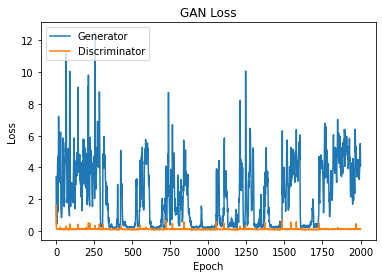

In [0]:
plot_loss(stablized_gen_loss,stablized_disc_loss )

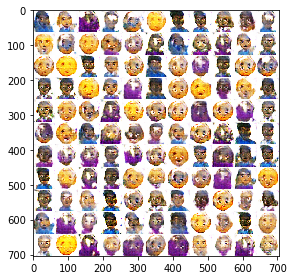

In [0]:
img_path = '/content/drive/My Drive/DL Assignments/PA 05/samples/generated_image_2000.png'
img = imread(img_path)
imshow(img)

### Analysis 
Repeat the above analysis and mention changes you observed in terms of training and quality of fake images

The Model showed lots of variation throughout the process. I had to tweak parameters again and again and change combination of techniques suggested for stablizing training the DCGAN.

Techniques that I have used in latest submission are smooth real labels, hard fake labels, normalizing training data and guassian sample noise.

My model has slight oscilation in losses. It does not exactly hits any failure mode but has spikes on some training data as it can be seen from plots above. On certain type of emojis, generator has high variation in loss, for some types, it is stable and quite close to discriminator. So, my model is kind of hitting a pseudo failure mode meaning for certain kind of emojis, it has failure mode, for some kinds, it is stable. 

## BONUS - 10%
The current training set was a subset of the actual emojis dataset. In the filtering process, most inanimate objects were removed and the focus was on front-facing emojis. Train the model over the full dataset or a subset of your choice and repeat the above analysis

In [0]:
def load_full_data():
    base_dir = 'Apple/Train/*'
    train_files = glob(base_dir)
    #print(glob(base_dir))
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

In [0]:
!unzip "/content/drive/My Drive/DL Assignments/PA 05/Apple.zip" -d "/content"

Archive:  /content/drive/My Drive/DL Assignments/PA 05/Apple.zip
  inflating: /content/Apple/Test/U+0030 U+FE0F U+20E3.png  
  inflating: /content/Apple/Test/U+264F.png  
  inflating: /content/Apple/Test/U+1F64C U+1F3FE.png  
  inflating: /content/Apple/Test/U+1F469 U+200D U+1F469 U+200D U+1F467 U+200D U+1F467.png  
  inflating: /content/Apple/Test/U+1F914.png  
  inflating: /content/Apple/Test/U+1F919 U+1F3FD.png  
  inflating: /content/Apple/Test/U+1F423.png  
  inflating: /content/Apple/Test/U+1F933 U+1F3FD.png  
  inflating: /content/Apple/Test/U+1F44C.png  
  inflating: /content/Apple/Test/U+1F36C.png  
  inflating: /content/Apple/Test/U+1F487 U+1F3FC U+200D U+2642 U+FE0F.png  
  inflating: /content/Apple/Test/U+1F590 U+1F3FF.png  
  inflating: /content/Apple/Test/U+1F6B4 U+1F3FF U+200D U+2640 U+FE0F.png  
  inflating: /content/Apple/Test/U+1F468 U+1F3FC U+200D U+1F4BC.png  
  inflating: /content/Apple/Test/U+1F469 U+200D U+1F4BC.png  
  inflating: /content/Apple/Test/U+1F3CA U+20

In [0]:
cd '/content'

/content


In [0]:
def full_gan_training_loop(intervals=200):
    # Setup Models here
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0003))
    
    #noise = sample_noise()
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0005))
    dcgan = build_gan(generator, discriminator)

    X_train = load_full_data()
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            # Write your code here
            # New smooth labels
            #real_labels = np.ones((BATCH_SIZE,), dtype=int)
            fake_labels = np.zeros((BATCH_SIZE,), dtype=int)
            real_labels = smooth_real_labels(BATCH_SIZE)
            #fake_labels = smooth_fake_labels(BATCH_SIZE)

            noise = guassain_sample_noise()
            train_sam = X_train[index:index+BATCH_SIZE]
            train_sam = normalize(train_sam)

            generated_imgs = generator.predict(noise)
            #normalized images
            #generated_imgs = normalize(generated_imgs) 

            real_disc = discriminator.train_on_batch(train_sam, real_labels)
            fake_disc = discriminator.train_on_batch(generated_imgs, fake_labels)

            if not (e % intervals):
                save_samples(generated_imgs,e, "full dataset samples")     
            
            
            disc_loss = (real_disc + fake_disc) * 0.5
            epoch_disc_loss.append(disc_loss)
            
            # Before training your generator using the combined model, freeze all layers of the discriminator first.
            for layer in discriminator.layers:
              layer.trainable = False

            # Unfreeze after your call to train_on_batch
            new_noise = guassain_sample_noise()

            # switching labels for generator after 9 epochs
            #if (e % 10 == 0):
              #print ("switching labels")
            #  gen_train = dcgan.train_on_batch(noise, fake_labels)
            #else:
            gen_train = dcgan.train_on_batch(new_noise, real_labels)
            
            gen_loss = gen_train

            for layer in discriminator.layers:
              layer.trainable = True

            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
            # Save weights here
            discriminator.save_weights(os.path.join(BASE_DIR,'discriminator'),True)
            generator.save_weights(os.path.join(BASE_DIR,'generator'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [0]:
full_disc_loss, full_gen_loss = full_gan_training_loop()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("rs..., outputs=Tensor("co...)`


['Apple/Train/U+1F1E6 U+1F1EA.png', 'Apple/Train/U+1F468 U+1F3FD U+200D U+1F52C.png', 'Apple/Train/U+1F3C2.png', 'Apple/Train/U+1F470 U+1F3FF.png', 'Apple/Train/U+1F32B.png', 'Apple/Train/U+1F1F8 U+1F1FF.png', 'Apple/Train/U+1F91E U+1F3FE.png', 'Apple/Train/U+1F359.png', 'Apple/Train/U+1F3C3 U+1F3FE U+200D U+2640 U+FE0F.png', 'Apple/Train/U+1F4FA.png', 'Apple/Train/U+1F352.png', 'Apple/Train/U+1F36D.png', 'Apple/Train/U+1F468 U+1F3FE U+200D U+1F373.png', 'Apple/Train/U+1F503.png', 'Apple/Train/U+23EE.png', 'Apple/Train/U+1F555.png', 'Apple/Train/U+1F472.png', 'Apple/Train/U+1F366.png', 'Apple/Train/U+1F646 U+1F3FF U+200D U+2640 U+FE0F.png', 'Apple/Train/U+1F482 U+1F3FD U+200D U+2640 U+FE0F.png', 'Apple/Train/U+1F470 U+1F3FB.png', 'Apple/Train/U+1F64E U+1F3FB.png', 'Apple/Train/U+1F93E U+1F3FC U+200D U+2640 U+FE0F.png', 'Apple/Train/U+1F91C U+1F3FD.png', 'Apple/Train/U+2716.png', 'Apple/Train/U+1F575.png', 'Apple/Train/U+1F939.png', 'Apple/Train/U+2714.png', 'Apple/Train/U+1F44A U+1F3FE

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


17/17 [==============================] - 10s 567ms/step
Epoch: 1 | Discriminator Loss: 0.526530 | Generator Loss: 0.936933
17/17 [==============================] - 4s 247ms/step
Epoch: 2 | Discriminator Loss: 0.128210 | Generator Loss: 0.356026
17/17 [==============================] - 4s 247ms/step
Epoch: 3 | Discriminator Loss: 0.129228 | Generator Loss: 3.028990
17/17 [==============================] - 4s 247ms/step
Epoch: 4 | Discriminator Loss: 0.120840 | Generator Loss: 0.516867
17/17 [==============================] - 4s 246ms/step
Epoch: 5 | Discriminator Loss: 0.115951 | Generator Loss: 0.301326
17/17 [==============================] - 4s 247ms/step
Epoch: 6 | Discriminator Loss: 0.107931 | Generator Loss: 0.773832
17/17 [==============================] - 4s 247ms/step
Epoch: 7 | Discriminator Loss: 0.112271 | Generator Loss: 1.172831
17/17 [==============================] - 4s 247ms/step
Epoch: 8 | Discriminator Loss: 0.106592 | Generator Loss: 0.657637
17/17 [================

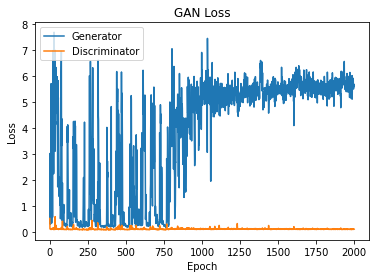

In [0]:
plot_loss(full_gen_loss, full_disc_loss)

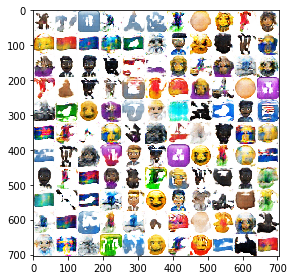

In [5]:
imgF_path = '/content/drive/My Drive/DL Assignments/PA 05/full dataset samples/generated_image_1800.png'
imgF = imread(imgF_path)
imshow(imgF)

The Model showed lots of variation throughout the process. I had to tweak parameters again and again and change combination of techniques suggested for stablizing training the DCGAN.

Techniques that I have used in latest submission are smooth real labels, hard fake labels, normalizing training data and guassian sample noise.

Initially when model started to learn on new dataset, it has spikes. As there is variety of emojis, model is trying to converge on the dataset. After 800 epochs, generator is giving a specific range of loss. It can be infer that model has analysed all the varities of emojis and is now improving its accuracy. Best result I have obtained is at 1800 epochs. After that, results start to go worse on some emojis. Could be that the reason model has started to overfit and underfit some emojis. 

Model hits a failure mode for epochs b/w 800 and 100 as there is a particular shift in loss behavior of generator, though there was almost insignificant change in discrminitor loss at the same time. After that, loss stays within a certain range and is stable. 
